# Loading data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from pyts.image import MarkovTransitionField
import dask.dataframe as dd  
import pandas as pd


from scipy import signal as sign
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import matthews_corrcoef

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

root_dir = "/home/polivares/scratch/Datasets/PowerLineFaults/"

X_train = np.load(root_dir + "dataset_mel/train/images_train.npy")
y_train = np.load(root_dir + "dataset_mel/train/labels_train.npy")
X_test = np.load(root_dir + "dataset_mel/test/images_test.npy")
y_test = np.load(root_dir + "dataset_mel/test/labels_test.npy")
X_val = np.load(root_dir + "dataset_mel/val/images_val.npy")
y_val = np.load(root_dir + "dataset_mel/val/labels_val.npy")

2022-10-07 17:18:52.801020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 17:18:53.037036: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-07 17:18:53.819663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-07 17:18:53.819784: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

# CNN-model

In [3]:
# Creación de modelo
model = models.Sequential()
# Capas encargadas de obtener información de la imagen
model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(256,256,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Capas para la clasificación en base a la información obtenida en 
# capas anteriores
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

2022-10-07 17:18:57.434626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 17:18:58.190619: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9638 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 256)     2560      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 256)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 flatten (Flatten)           (None, 230400)            0

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience = 7)

checkpoint_path='CNN-model_mel.ckpt'
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(loss = 'bce', optimizer = 'adam', metrics=['accuracy', tf.keras.metrics.Recall()])
history_cnn = model.fit(X_train, y_train, epochs=100, 
                        validation_data=(X_val, y_val),
                        batch_size=10,
                        callbacks=[early_stopping, cp_callback])

Epoch 1/100


2022-10-07 17:19:04.414494: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


488/488 [==============================] - ETA: 0s - loss: 1.0620 - accuracy: 0.9340 - recall: 0.0068
Epoch 1: saving model to CNN-model_mel.ckpt
488/488 [==============================] - 25s 44ms/step - loss: 1.0620 - accuracy: 0.9340 - recall: 0.0068 - val_loss: 0.2176 - val_accuracy: 0.9402 - val_recall: 0.0000e+00
Epoch 2/100
487/488 [============================>.] - ETA: 0s - loss: 0.1990 - accuracy: 0.9398 - recall: 0.0000e+00
Epoch 2: saving model to CNN-model_mel.ckpt
488/488 [==============================] - 21s 43ms/step - loss: 0.1994 - accuracy: 0.9397 - recall: 0.0000e+00 - val_loss: 0.2094 - val_accuracy: 0.9402 - val_recall: 0.0000e+00
Epoch 3/100
487/488 [============================>.] - ETA: 0s - loss: 0.1736 - accuracy: 0.9400 - recall: 0.0170
Epoch 3: saving model to CNN-model_mel.ckpt
488/488 [==============================] - 21s 43ms/step - loss: 0.1733 - accuracy: 0.9401 - recall: 0.0170 - val_loss: 0.2783 - val_accuracy: 0.9402 - val_recall: 0.0000e+00
Epoch

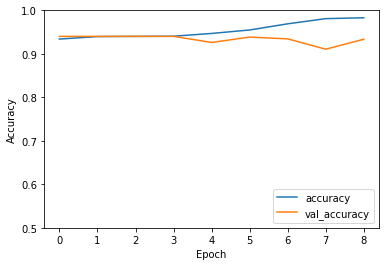

In [5]:
plt.plot(history_cnn.history['accuracy'], label='accuracy')
plt.plot(history_cnn.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

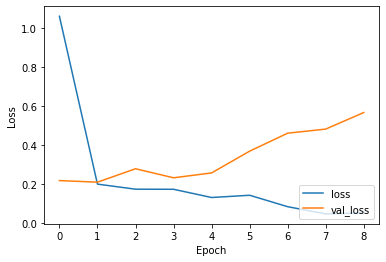

In [6]:
plt.plot(history_cnn.history['loss'], label='loss')
plt.plot(history_cnn.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [7]:
val_loss, val_acc, val_recall = model.evaluate(X_val,  y_val, verbose=2, batch_size=4)

305/305 - 3s - loss: 0.5674 - accuracy: 0.9336 - recall: 0.0548 - 3s/epoch - 8ms/step


In [8]:
val_predictions = (model.predict(X_val, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
val_real_values = y_val.T[0]

305/305 [==============================] - 2s 5ms/step


In [9]:
matthews_corrcoef(val_real_values, val_predictions)

0.09242545425819584

In [10]:
test_loss, test_acc, test_recall = model.evaluate(X_test,  y_test, verbose=2, batch_size=4)

654/654 - 5s - loss: 0.5128 - accuracy: 0.9269 - recall: 0.1013 - 5s/epoch - 7ms/step


In [11]:
test_predictions = (model.predict(X_test, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
test_real_values = y_test.T[0]

654/654 [==============================] - 4s 5ms/step


In [12]:
matthews_corrcoef(test_real_values, test_predictions)

0.12444289344870849

# Resnet-model

In [13]:
# Transfer Learning
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False # Esto impide que las capas se re entrenen

In [14]:
X_train_rgb = np.repeat(X_train, 3, -1)
X_val_rgb = np.repeat(X_val, 3, -1)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience = 7)

checkpoint_path='Resnet50-model_mel.ckpt'
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(loss = 'bce', optimizer = 'adam', metrics=['accuracy', tf.keras.metrics.Recall()])
history_resnet = model.fit(X_train_rgb, y_train, epochs=100, 
                        validation_data=(X_val_rgb, y_val),
                        batch_size=10,
                        callbacks=[early_stopping, cp_callback])

Epoch 1/100
488/488 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.9391 - recall_1: 0.0272
Epoch 1: saving model to Resnet50-model_mel.ckpt
488/488 [==============================] - 24s 41ms/step - loss: 0.2040 - accuracy: 0.9391 - recall_1: 0.0272 - val_loss: 0.1928 - val_accuracy: 0.9434 - val_recall_1: 0.1096
Epoch 2/100
487/488 [============================>.] - ETA: 0s - loss: 0.1825 - accuracy: 0.9419 - recall_1: 0.0816
Epoch 2: saving model to Resnet50-model_mel.ckpt
488/488 [==============================] - 18s 37ms/step - loss: 0.1823 - accuracy: 0.9420 - recall_1: 0.0816 - val_loss: 0.1853 - val_accuracy: 0.9443 - val_recall_1: 0.0822
Epoch 3/100
487/488 [============================>.] - ETA: 0s - loss: 0.1777 - accuracy: 0.9425 - recall_1: 0.0956
Epoch 3: saving model to Resnet50-model_mel.ckpt
488/488 [==============================] - 18s 37ms/step - loss: 0.1778 - accuracy: 0.9422 - recall_1: 0.0952 - val_loss: 0.1785 - val_accuracy: 0.9443 - v

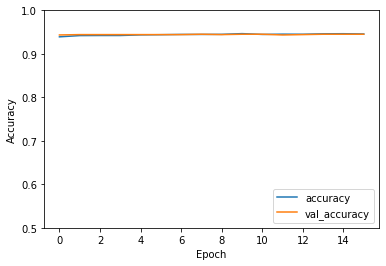

In [16]:
plt.plot(history_resnet.history['accuracy'], label='accuracy')
plt.plot(history_resnet.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

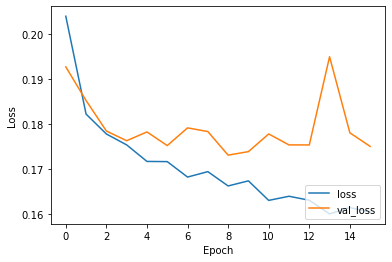

In [17]:
plt.plot(history_resnet.history['loss'], label='loss')
plt.plot(history_resnet.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [18]:
val_loss, val_acc, val_recall = model.evaluate(X_val_rgb,  y_val, verbose=2, batch_size=4)

305/305 - 8s - loss: 0.1751 - accuracy: 0.9451 - recall_1: 0.0959 - 8s/epoch - 26ms/step


In [19]:
val_predictions = (model.predict(X_val_rgb, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
val_real_values = y_val.T[0]

305/305 [==============================] - 7s 20ms/step


In [20]:
matthews_corrcoef(val_real_values, val_predictions)

0.279225663784422

In [ ]:
X_test_rgb = np.repeat(X_test, 3, -1)
test_loss, test_acc, test_recall = model.evaluate(X_test_rgb,  y_test, verbose=2, batch_size=4)

In [ ]:
test_predictions = (model.predict(X_test_rgb, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
test_real_values = y_test.T[0]

In [ ]:
matthews_corrcoef(test_real_values, test_predictions)